# **Data Dictionary**

- <b>Gender</b> : Sex of individual
- <b>Age</b> : How old is the individual
- <b>Height</b> : How tall is the individual
- <b>Weight</b> : How heavy is the individual
- <b>family_history_with_overweight</b> :Family history of obesity
- <b>FAVC</b> : Frequency of consumption of high-calorie foods
- <b>FCVC</b> : Frequency of vegetable consumption
- <b>NCP</b> : Number of main meals
- <b>CAEC</b> : Food consumption between meals
- <b>SMOKE</b> : Tobacco use
- <b>CH20</b> : Daily water consumption
- <b>SCC</b> : Monitoring calorie consumption.
- <b>FAF</b> : Frequency of physical activity
- <b>TUE</b> : Time for using technological devices
- <b>CALC</b> : Alcohol consumption
- <b>MTanANS</b> : Mode of transport used
- <b>NObeyesdad</b> : Gives us the obesity status of the person

# **Coletando Dados**

Os dados foram disponibilizados em meu github público. Eu subi esses arquivos no github e estou usando esse script pronto para carregar esses arquivos no Google Colab.

In [1]:
import os
import zipfile
import requests
from io import BytesIO

def download_and_extract_github_folder(repo_url, branch, folder_path, target_path):
    zip_url = f"{repo_url}/archive/{branch}.zip"

    print("Downloading the zip file...")
    response = requests.get(zip_url, stream=True)
    zip_file = zipfile.ZipFile(BytesIO(response.content))

    print("Extracting files...")
    for file in zip_file.namelist():
        if file.startswith(f"{repo_url.split('/')[-1]}-{branch}/{folder_path}"):
            zip_file.extract(file, target_path)

    extracted_folder = os.path.join(target_path, f"{repo_url.split('/')[-1]}-{branch}", folder_path)
    os.system(f"mv {extracted_folder}/* {target_path}")
    os.system(f"rm -r {target_path}/{repo_url.split('/')[-1]}-{branch}")

    print("Files are ready to use at:", target_path)

repo_url = 'https://github.com/geeklicantropo/MESTRADO_PUBLICO'
branch = 'main'
folder_path = 'DATA_MINING/TAREFAS/Tarefa1/data/'
target_path = '/content/'

download_and_extract_github_folder(repo_url, branch, folder_path, target_path)


Extracting files...
Files are ready to use at: /content/


# **Loading libraries**

In [2]:
import pandas as pd
import numpy as np

#Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning - Modelagem e Avaliação
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Algoritmos preditivos
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

#Biblioteca para mostrar barras de progresso em loops.
from tqdm import tqdm

#Estatísticas
from scipy.stats import chi2_contingency, f_oneway, spearmanr, skew

In [3]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")


# **EDA**

Aqui estou fazendo a análise exploratória dos dados, para investigar quaisquer informações implícitas nos dados que possa me ajudar a criar um modelo de classificação assertivo.

In [4]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
test.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [6]:
train.shape

(20758, 18)

In [7]:
test.shape

(13840, 17)

**Criando uma classe para múltiplas tarefas de EDA**

Aqui estou encapsulando múltiplas tarefas da análise exploratória dos dados em uma única classe.


In [8]:
class EDA:
    def __init__(self, data, target_col):
        self.data = data
        self.target_col = target_col
        self.target_data = data[target_col]

    #Principais análises estatísticas
    def data_summary(self):
      display(self.data.describe(include='all').transpose())

    #Verificar valores nulos
    def missing_value_analysis(self):
      display(
          pd.DataFrame(
              self.data.isnull().sum(axis = 0) / len(self.data) * 100, columns = ['Null Value Ratio']
          ).applymap(lambda x: f"{np.round(x, decimals = 5)}%")
      )

    #Checar os tipos de dados
    def checking_datatypes(self):
      display(self.data.dtypes)

    #Checar linhas duplicadas
    def verify_duplicates(self):
      n_duplicates = self.data.duplicated().sum()
      print(f"Number of duplicates: {n_duplicates}.")

    #Checar a distribuição dos dados de maneira visual
    def data_distribution(self):
      numerical_cols = self.data.select_dtypes(include=['float64', 'int64']).columns
      categorical_cols = self.data.select_dtypes(include=['object', 'category']).columns

      #Determina o número de linhas necessárias para subplots
      total_cols = len(numerical_cols) + len(categorical_cols)
      num_rows = (total_cols + 3) // 4  #Garanta linhas suficientes adicionando 3 antes da divisão inteira por 4

      #Cria um esboço de imagem maior que irá conter os subplots
      fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, num_rows * 4))
      axes = axes.flatten()  #Estratégia usada para evitar erros

      #Plotando historigramas para features numéricas
      for idx, col in enumerate(numerical_cols):
          if idx < len(axes):  #Estratégia usada para evitar erros
              sns.histplot(self.data[col], kde=True, bins=30, color='blue', ax=axes[idx])
              axes[idx].set_title(f'Distribution of {col}')

      #Plotando gráficos de barras para features categóricas
      offset = len(numerical_cols)  #Começa a plotar as variáveis categóricas depois das numéricas
      for idx, col in enumerate(categorical_cols, start=offset):
          if idx < len(axes):  #Estratégia usada para evitar erros
              sns.countplot(x=self.data[col], ax=axes[idx])
              axes[idx].set_title(f'Distribution of {col}')
              axes[idx].tick_params(axis='x', rotation=45)

      #Esconde qualquer eixo não usado
      for ax in axes[total_cols:]:
          ax.axis('off')

      plt.tight_layout()
      plt.show()

    #Identifica outliers usando o intervalo interquantil
    def identify_outliers(self):
      numerical_features = self.data.select_dtypes(include=['float64', 'int64']).columns
      outliers_info = {}

      # Dicionário com as descrições das variáveis
      descriptions = {
          'FAF': 'Frequency of physical activity',
          'Gender' : 'Sex of individual',
          'Age' : 'How old is the individual',
          'Height' : 'How tall is the individual',
          'Weight' : 'How heavy is the individual',
          'family_history_with_overweight' :'Family history of obesity',
          'FAVC' : 'Frequency of consumption of high-calorie foods',
          'FCVC' : 'Frequency of vegetable consumption',
          'NCP' : 'Number of main meals',
          'CAEC' : 'Food consumption between meals',
          'SMOKE' : 'Tobacco use',
          'CH2O' : 'Daily water consumption',
          'SCC' : 'Monitoring calorie consumption',
          'FAF' : 'Frequency of physical activity',
          'TUE' : 'Time for using technological devices',
          'CALC' : 'Alcohol consumption',
          'MTanANS' : 'Mode of transport used',
          'NObeyesdad' : 'Gives us the obesity status of the person'
      }

      #Determine o número de linhas necessárias para subplots
      total_cols = len(numerical_features)
      num_rows = (total_cols + 3) // 4

      #Cria um conjunto de subplots onde em cada linha, teremos no máximo 4 subplots
      fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, num_rows * 4))
      axes = axes.flatten()

      #Loop sobre todas as features numéricas para calcular e plotar os outliers
      for idx, feature in enumerate(numerical_features):
          Q1 = self.data[feature].quantile(0.25)
          Q3 = self.data[feature].quantile(0.75)
          IQR = Q3 - Q1

          lower_bound = Q1 - 1.5 * IQR
          upper_bound = Q3 + 1.5 * IQR

          outliers = self.data[(self.data[feature] < lower_bound) | (self.data[feature] > upper_bound)]
          outliers_info[feature] = {'count': len(outliers), 'outliers': outliers}

          #Plota cada boxplot em seu respectivo subplot
          sns.boxplot(y=self.data[feature], color='orange', ax=axes[idx])
          full_title = descriptions.get(feature, feature)  #Pega a descrição completa do dicionário de descriptions
          axes[idx].set_title(f'Outliers in {feature} ({full_title})')

      #Oculta quaisquer eixos não utilizados se o número de features for menor que o número de subplots
      for i in range(idx + 1, len(axes)):
          axes[i].axis('off')

      plt.tight_layout()
      plt.show()

      return outliers_info

    #Analisa a assimetria das features e plota os resultados
    def analyze_skewness(self):
      numerical_features = self.data.select_dtypes(include=['float64', 'int64']).columns
      skew_info = {}

      #Calcular número de subplots necessário
      total_features = len(numerical_features)
      num_rows = (total_features + 3) // 4
      fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, num_rows * 4))
      axes = axes.flatten()  #Garante que axes seja sempre um array 1D, mesmo com um único subplot

      #Calcular assimetria e plotar para cada feature
      for idx, feature in enumerate(numerical_features):
          skewness = skew(self.data[feature].dropna())
          skew_info[feature] = skewness
          sns.histplot(self.data[feature], kde=True, color='purple', ax=axes[idx])
          axes[idx].set_title(f'Skewness of {feature}: {skewness:.2f}')

      #Ocultar eixos extras se houver
      for i in range(idx + 1, len(axes)):
          axes[i].axis('off')
      plt.tight_layout()
      plt.show()

      return skew_info

    #Cria o gráfico de correlação (Heatmap)
    def correlation_analysis_heatmap(self, skew_threshold=1):
        '''
          Verifica a assimetria usando a função de analisar assimetria. Isso é importante porque
          se a feature for assimétrica (skeweness acima de 1), usar a correlação de Pearson não irá funcionar.
          Como alternativa, a correlação de Spearman será usada.
        '''
        skew_info = self.analyze_skewness()
        skewed_features = any(abs(skew) > skew_threshold for skew in skew_info.values())

        corr_data = self.data.copy()
        for column in corr_data.select_dtypes(include=['object', 'category']).columns:
            corr_data[column] = corr_data[column].astype('category').cat.codes

        #Define o método de correlação baseado na assimetria.
        correlation_method = 'spearman' if skewed_features else 'pearson'
        correlation_matrix = corr_data.corr(method=correlation_method)

        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
        plt.title(f'Correlation Matrix using {correlation_method.capitalize()}')
        plt.show()

        return correlation_matrix


In [9]:
#Aqui estou criando uma cópia do dataframe do trem apenas para deletar a coluna id e fazer algum EDA
df_train = train.copy()
df_train = df_train.drop(labels=["id"], axis=1)

In [10]:
#Cria uma instância da classe de EDA para a análise exploratória de dados
analyzer = EDA(df_train, 'NObeyesdad')

In [11]:
#Análises estatísticas principais
print("Resumo dos dados")
analyzer.data_summary()

Resumo dos dados


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,20758,2,Female,10422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,20758.0,NaN,NaN,NaN,23.841804,5.688072,14.0,20.0,22.815416,26.0,61.0
Height,20758.0,NaN,NaN,NaN,1.700245,0.087312,1.45,1.631856,1.7,1.762887,1.975663
Weight,20758.0,NaN,NaN,NaN,87.887768,26.379443,39.0,66.0,84.064875,111.600553,165.057269
family_history_with_overweight,20758,2,yes,17014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAVC,20758,2,yes,18982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FCVC,20758.0,NaN,NaN,NaN,2.445908,0.533218,1.0,2.0,2.393837,3.0,3.0
NCP,20758.0,NaN,NaN,NaN,2.761332,0.705375,1.0,3.0,3.0,3.0,4.0
CAEC,20758,4,Sometimes,17529,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SMOKE,20758,2,no,20513,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#Verifica valores nulos
analyzer.missing_value_analysis()

,Null Value Ratio
Gender,0.0%
Age,0.0%
Height,0.0%
Weight,0.0%
family_history_with_overweight,0.0%
FAVC,0.0%
FCVC,0.0%
NCP,0.0%
CAEC,0.0%
SMOKE,0.0%


In [13]:
#Verifica os tipos de dados
analyzer.checking_datatypes()

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [14]:
#Verifica linhas duplicadas
analyzer.verify_duplicates()

Number of duplicates: 0.


* A obesidade tipo 3 (o pior tipo) é a mais comum, infelizmente
* Existem alguns valores discrepantes para algumas colunas, especialmente Age
* A coluna Age é um valor do tipo Float. Ela precisa ser alterada para um inteiro
* Existem algumas features muito desbalanceadas
* Não temos problemas com valores nulos
* Não temos problemas com duplicatas também.

Distribuição de Dados:


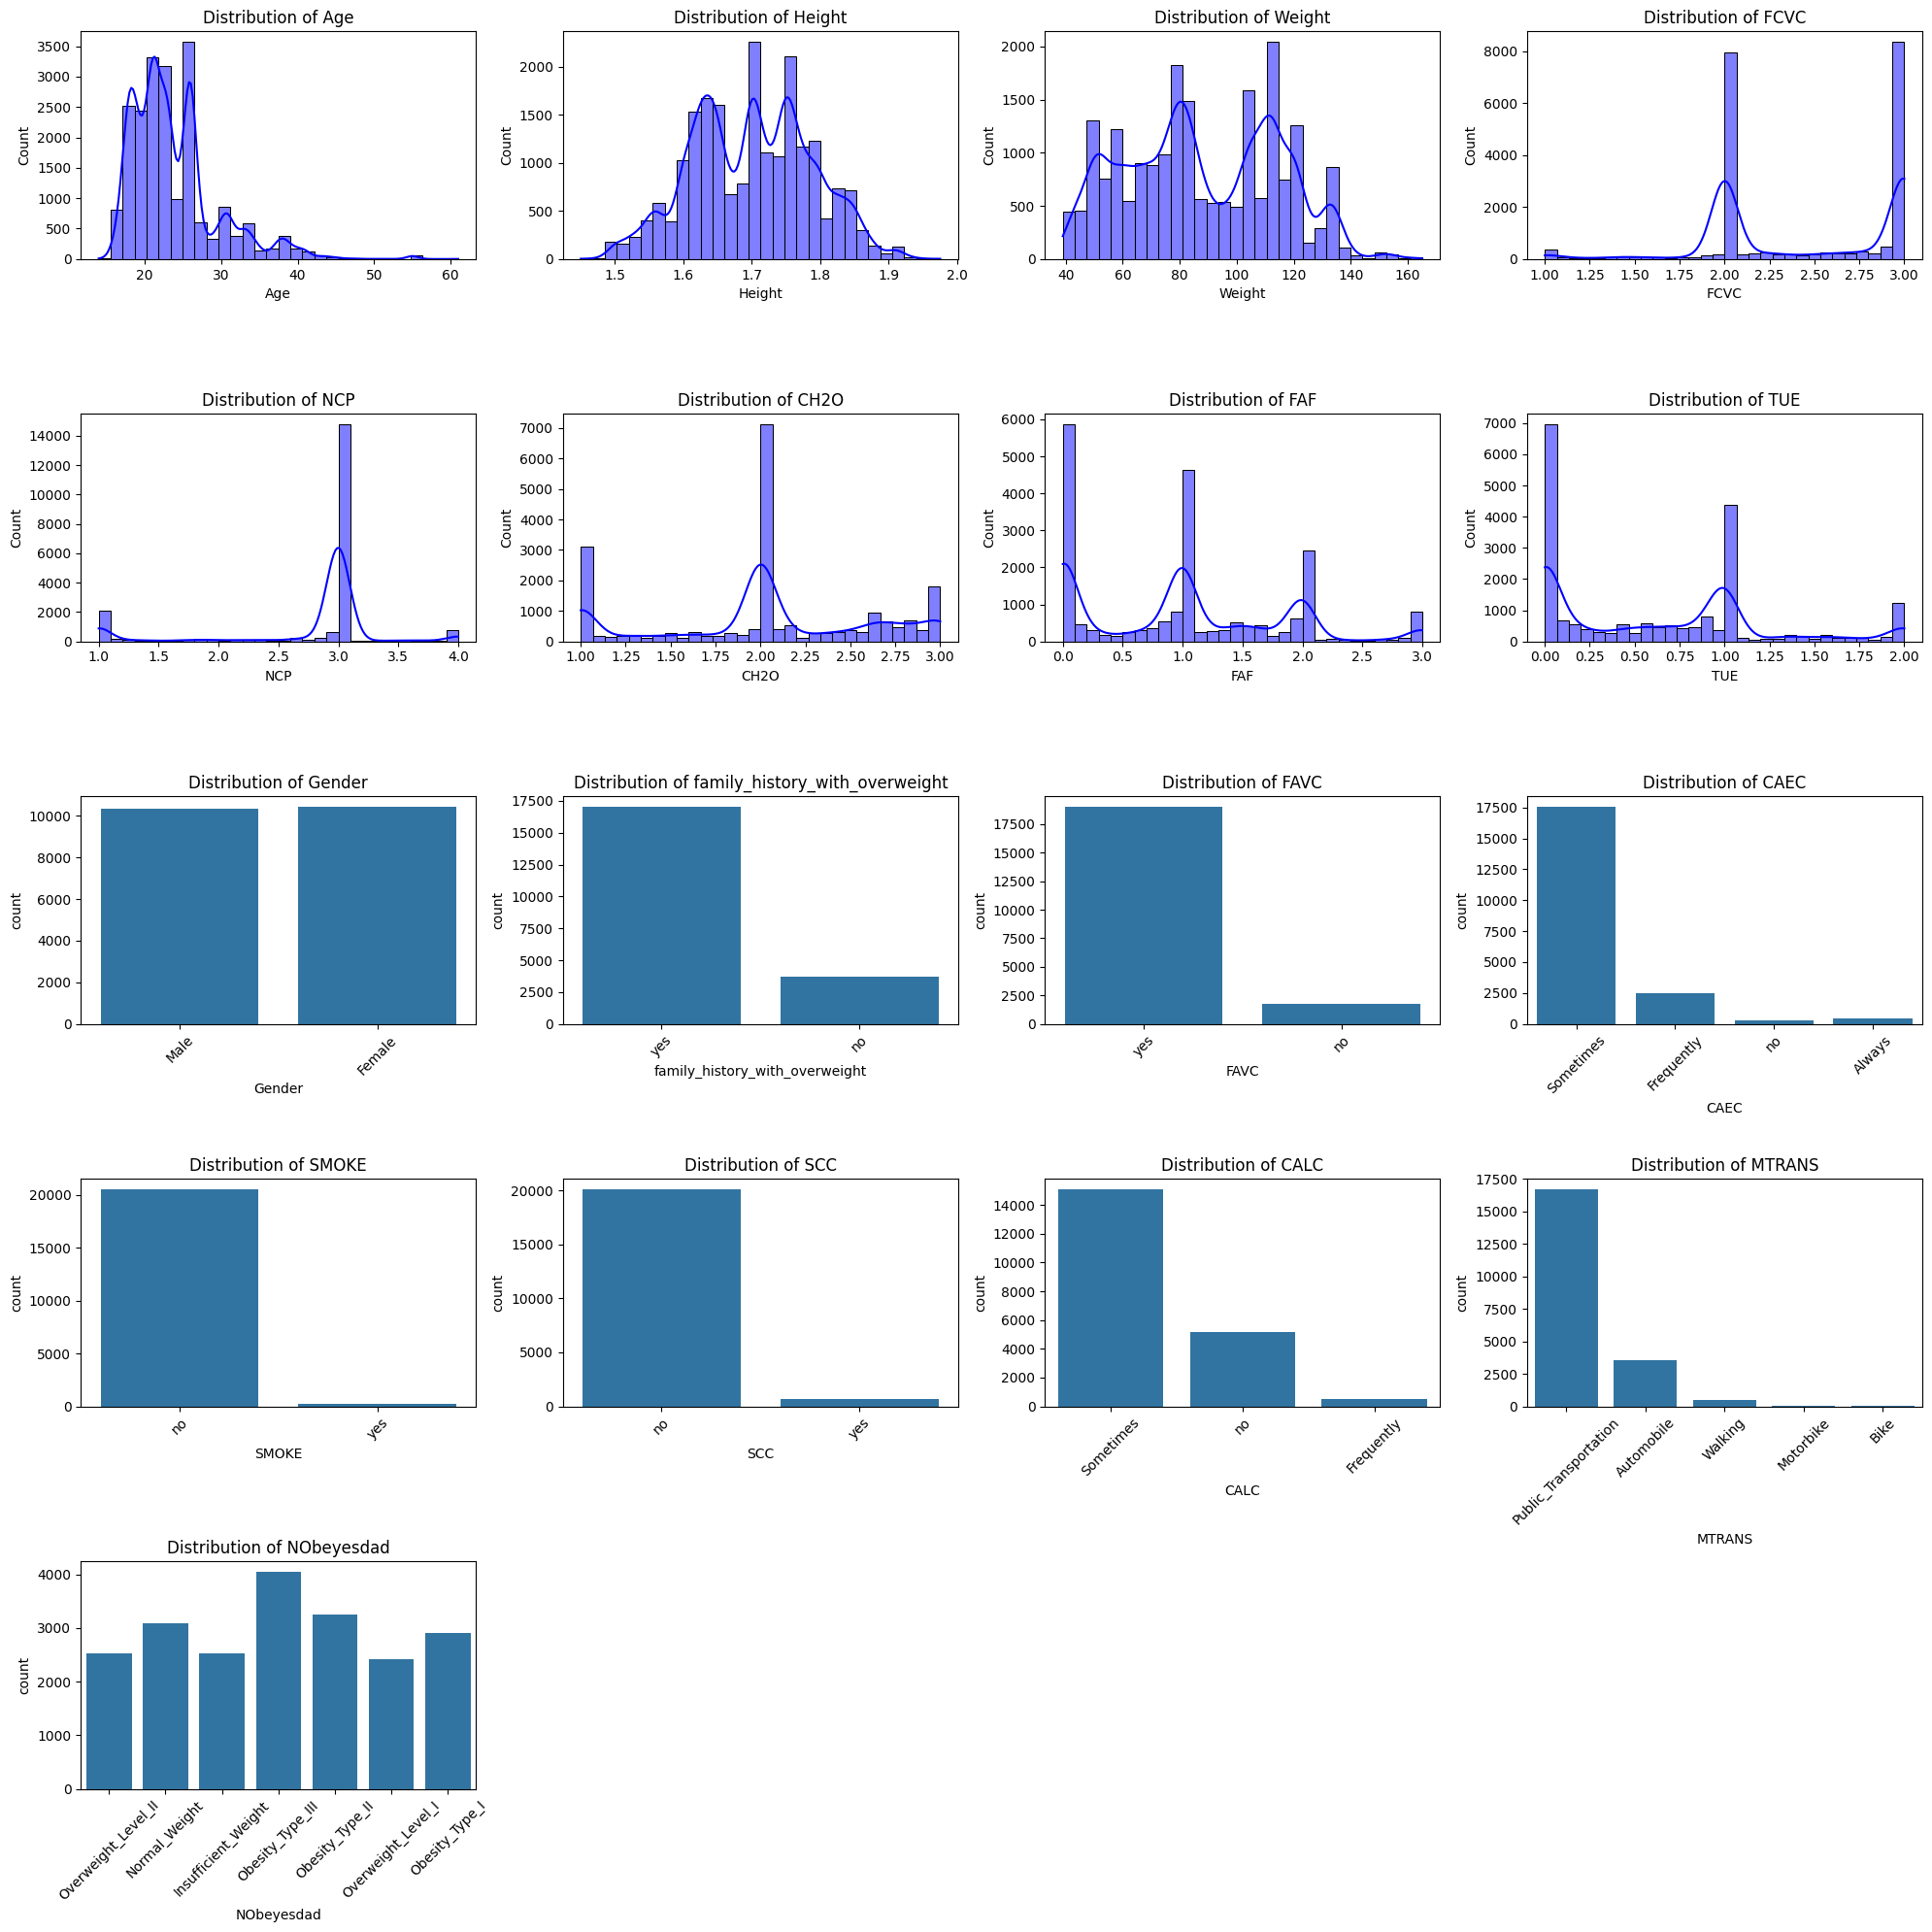

In [15]:
#Verifica a distribuição dos dados
print("Distribuição de Dados:")
analyzer.data_distribution()

* O histograma que mostra gráficos numéricos está skewed na maioria das features.
* Apenas Height e Weight e Age têm uma distribuição que parece uma distribuição normal.
* Precisamos aplicar a normalização a esses dados.
* Os valores categóricos são em sua maioria desequilibrados. Apenas a coluna Gender está bem equilibrada




Identificando e plotando outliers:


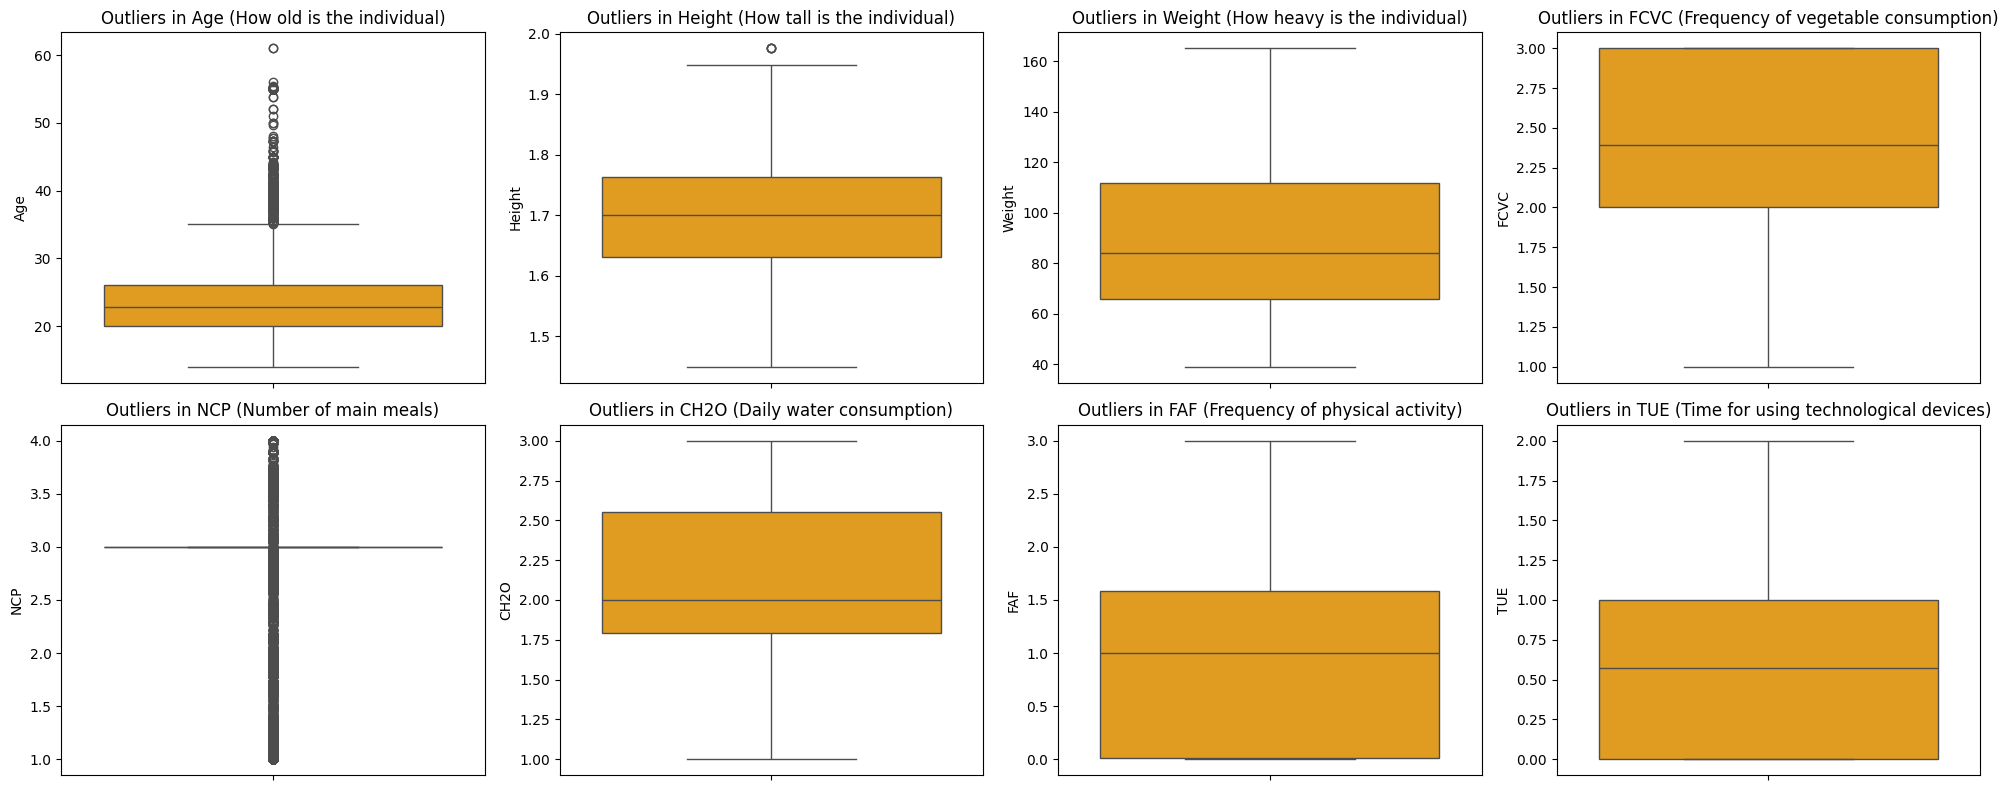

Age tem 1074 outliers
Height tem 4 outliers
Weight tem 0 outliers
FCVC tem 0 outliers
NCP tem 6052 outliers
CH2O tem 0 outliers
FAF tem 0 outliers
TUE tem 0 outliers


In [16]:
# Identificar e imprimir informações sobre outliers
print("\nIdentificando e plotando outliers:")
outliers_info = analyzer.identify_outliers()
for feature, details in outliers_info.items():
    print(f"{feature} tem {details['count']} outliers")

* Como identificado antes, Age tem a maior quantidade de outliers.
* NCP possui valores entre 1 e 4. Se todos ou a maioria dos dados estão concentrados em um único valor ou em poucos valores muito próximos, será difícil enxergar o boxplot. Neste caso, o primeiro quartil (Q1), a mediana (Q2) e o terceiro quartil (Q3) podem ser todos iguais ou muito próximos.
* Eu entendo que o NCP deveria ser uma variável inteira e não um float.


Analisando visualmente a assimetria dos dados:


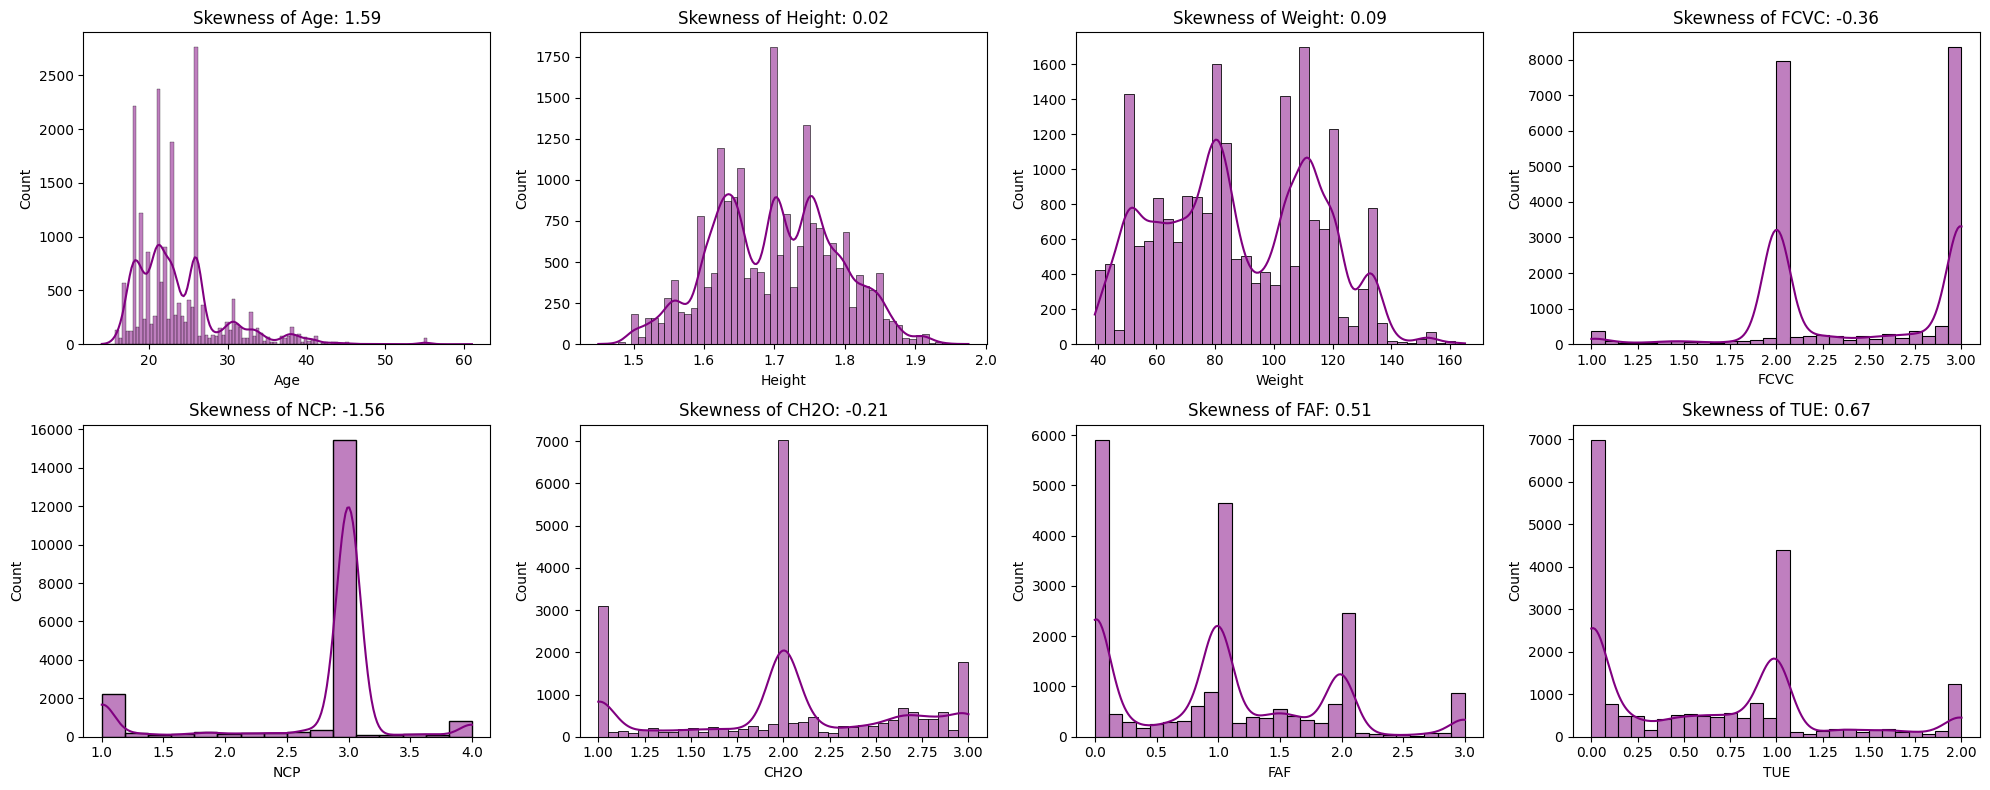

Informações de Skewness:
Age: Skewness = 1.59
Height: Skewness = 0.02
Weight: Skewness = 0.09
FCVC: Skewness = -0.36
NCP: Skewness = -1.56
CH2O: Skewness = -0.21
FAF: Skewness = 0.51
TUE: Skewness = 0.67


In [17]:
# Analisar e imprimir informações sobre a assimetria (skewness)
print("\nAnalisando visualmente a assimetria dos dados:")
skew_info = analyzer.analyze_skewness()
print("Informações de Skewness:")
for feature, skewness in skew_info.items():
    print(f"{feature}: Skewness = {skewness:.2f}")

O **skew_threshold** é um parâmetro que define o limite para considerar uma distribuição como significativamente assimétrica ou normal.

Se o skewness é um valor:

* Próximo a 0 indica uma distribuição simétrica (normal).
* Maior que 0 indica uma assimetria positiva (cauda longa à direita).
* Menor que 0 indica uma assimetria negativa (cauda longa à esquerda).
* Valor maior que 1 sugere uma distribuição altamente assimétrica.

Somente Height e Weight possuem um valor de skill mais ou menos simétrico.


Heatmap que mostra a correlação dentre todas as features:


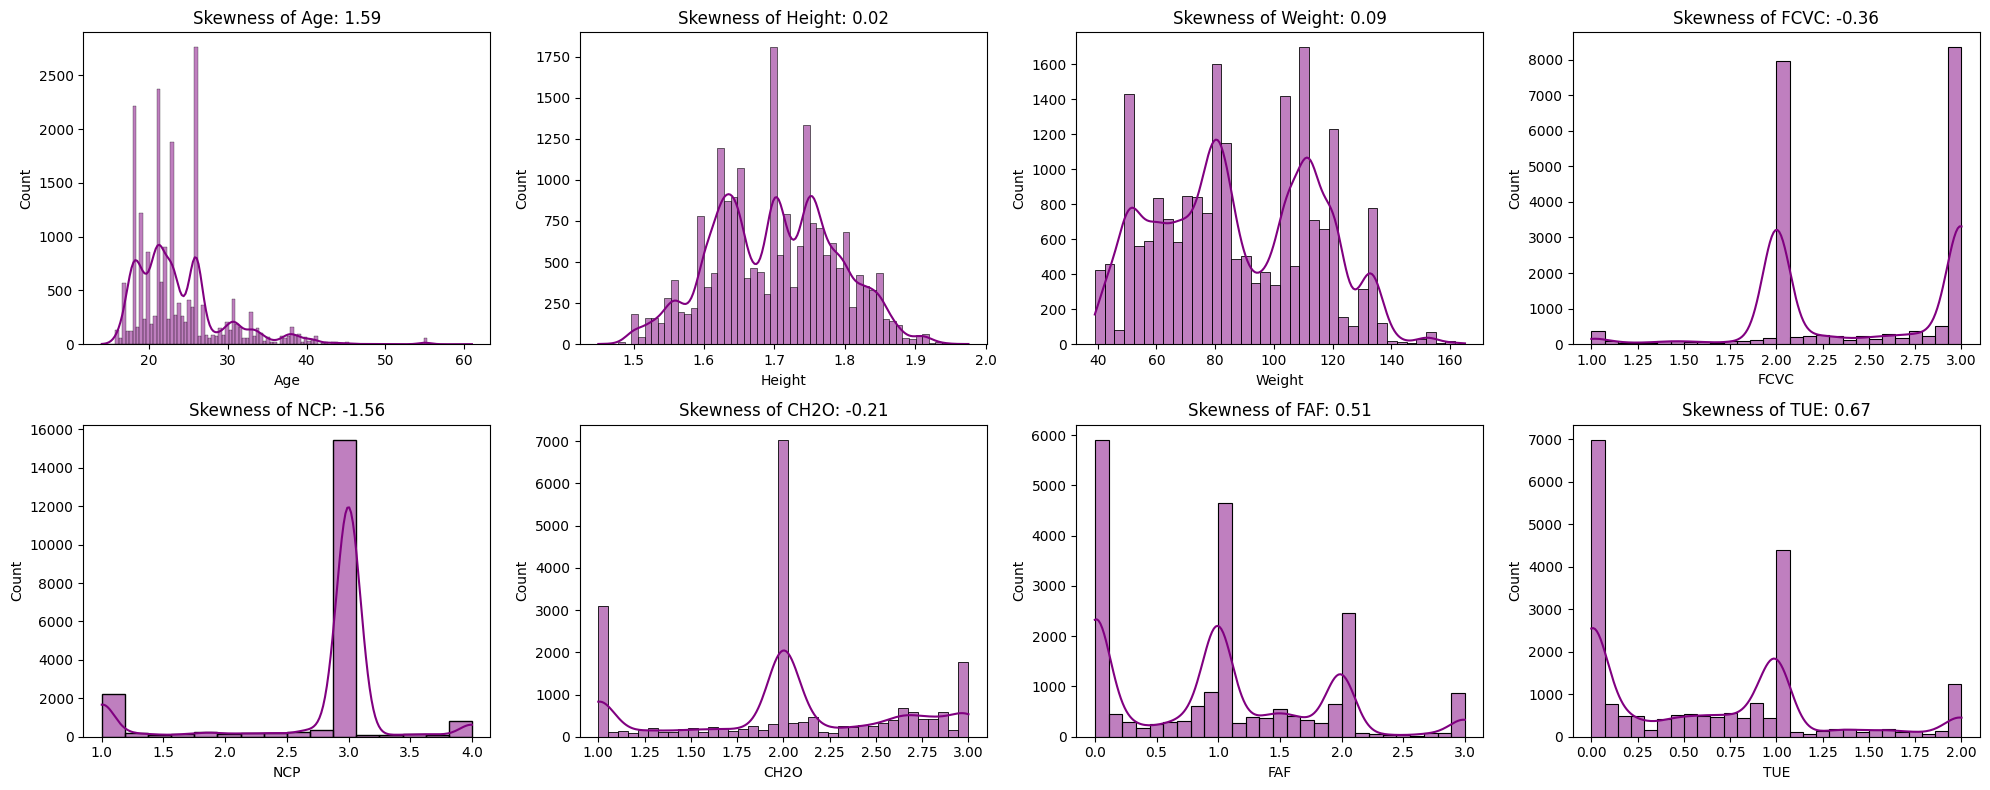

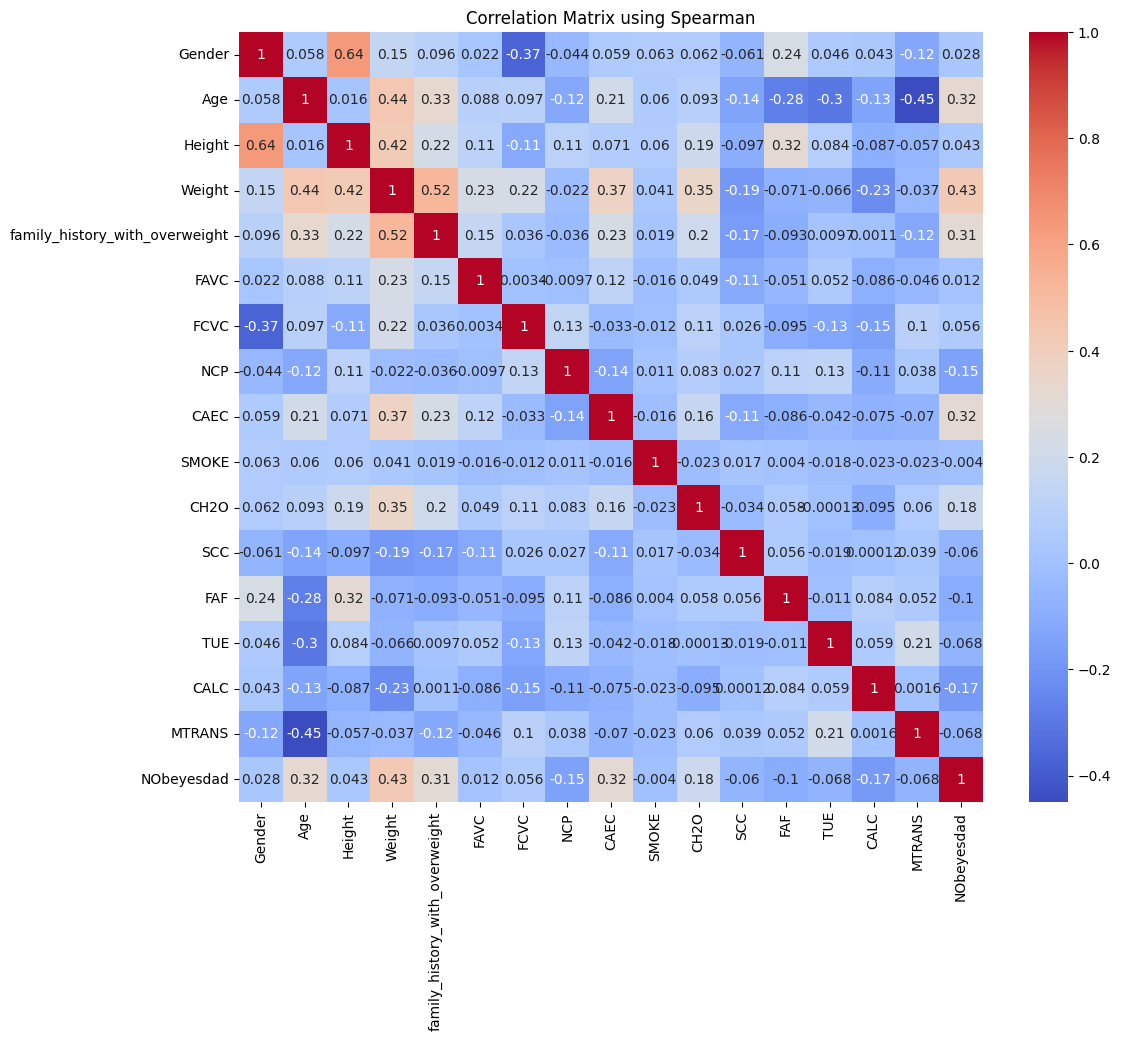

In [18]:
#Realizar análise de correlação e imprimir a matriz de correlação
print("\nHeatmap que mostra a correlação dentre todas as features:")
correlation_matrix = analyzer.correlation_analysis_heatmap()

* Como era de se esperar, a variável weight é a variável que possui maior correlação com a variável alvo.
* CAEC : Food consumption between meals, também possui uma significativa correlação com a variável alvo
* Age and family_history_with_overweight é altamente correlacionada com a variável alvo.
* Gender não tem uma correlação muito alta com a variável alto, ao contrário do que o senso comum possa dizer.

In [19]:
train.CALC.value_counts()

CALC
Sometimes     15066
no             5163
Frequently      529
Name: count, dtype: int64

In [20]:
test.CALC.value_counts()

CALC
Sometimes     9979
no            3513
Frequently     346
Always           2
Name: count, dtype: int64

# **Feature Engineering**

Baseado nas informações coletadas pela análise exploratória de dados, algumas mudanças nas features se fazem necessárias.
* Em alguns casos, os seus tipos de dados precisam ser alterados.
* Em outros casos, algumas features precisa ter os seus valores normalizados.
* Algumas novas colunas precisam ser criadas.

In [21]:
train.head(2)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.66995,yes,yes,2.0,2.983297,Sometimes,no,2.763573,no,0.0,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.00000,yes,yes,2.0,3.000000,Frequently,no,2.000000,no,1.0,1.000000,no,Automobile,Normal_Weight


In [22]:
#Função para aplicar transformações nos dados
def feature_engineering(data):
    #Transformar todas as colunas numéricas para float, exceto 'Age'
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

    #Converte as colunas para os seus tipos adequados
    data[numerical_cols] = data[numerical_cols].astype(float)
    data['id'] = data['id'].astype(int)
    data['Age'] = data['Age'].astype(int)
    data['CH2O'] = data['CH2O'].astype(int)

    #Criar nova coluna para Age em escalas de 10 em 10
    data['Age_Scale'] = data['Age'] // 10 + 1

    #Criar nova coluna para Weight em escalas de 20 em 20
    data['Weight_Scale'] = data['Weight'] // 20 + 1

    #Criar nova coluna para Height em escalas de 10 em 10 centímetros
    #Encontrar o mínimo e o máximo da coluna 'Height'
    min_height = data['Height'].min()
    max_height = data['Height'].max()
    #Arredondar para baixo o mínimo e para cima o máximo para o múltiplo de 0.1 mais próximo
    min_height = np.floor(min_height * 10) / 10
    max_height = np.ceil(max_height * 10) / 10
    #Criar os bins a partir do mínimo ao máximo com incrementos de 0.1 metros
    bins = np.arange(min_height, max_height + 0.1, 0.1)  #Usar np.arange para garantir inclusão do último intervalo
    #Usar pd.cut para categorizar os valores de 'Height' e obter os códigos dos bins
    data['Height_bin'] = pd.cut(data['Height'], bins=bins, right=False, labels=False)
    #Calcular o ponto médio de cada bin para atribuir à nova coluna 'Height_scale'
    data['Height_scale'] = [(bins[i] + bins[i+1])/2 for i in data['Height_bin']]
    #Dropar coluna Height_bin
    data = data.drop(labels=["Height_bin"], axis=1)

    #Calcular o Índice de Massa Corporal (BMI)
    data['BMI'] = data['Weight'] / (data['Height'] ** 2)

    #Arredondar todas as colunas float para 2 casas decimais
    for column in data.select_dtypes(include=['float64']).columns:
        data[column] = data[column].round(2)

    #Transformar colunas binárias
    binary_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
    binary_mapping = {'yes': 1, 'no': 0, 'true': 1, 'false': 0, 'male': 1, 'female': 0}
    for column in binary_columns:
        #Certificar-se de que a coluna é de tipo string e lida com valores ausentes
        data[column] = data[column].astype(str).str.lower().replace(binary_mapping)

    # Corrigir o valor "Always" na coluna CALC para "Frequently"
    data['CALC'] = data['CALC'].replace('Always', 'Frequently')

    #Transformar colunas categóricas em números, considerando sua ordem hierárquica (na maioria das features)
    data['CAEC'] = data['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
    data['CALC'] = data['CALC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2})
    data['MTRANS'] = data['MTRANS'].astype('category').cat.codes  #Sem hierarquia específica, encoding ordinal

    if "NObeyesdad" in data.columns:
      data['NObeyesdad'] = data['NObeyesdad'].map({
          'Insufficient_Weight': 0,
          'Normal_Weight': 1,
          'Overweight_Level_I': 2,
          'Overweight_Level_II': 3,
          'Obesity_Type_I': 4,
          'Obesity_Type_II': 5,
          'Obesity_Type_III': 6
      })

    return data



In [23]:
# Aplicar a função de feature engineering
df_transformed = train.copy()
df_transformed = feature_engineering(df_transformed)
df_transformed = df_transformed.drop(labels=["id"], axis=1)

In [24]:
df_transformed.head(2)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,Age_Scale,Weight_Scale,Height_scale,BMI
0,1,24,1.70,81.67,1,1,2.0,2.98,1,0,...,0,0.0,0.98,1,3,3,3,5.0,1.65,28.26
1,0,18,1.56,57.00,1,1,2.0,3.00,2,0,...,0,1.0,1.00,0,0,1,2,3.0,1.55,23.42


# **Encontrando as features mais importantes**

Um processo será rodado abaixo com 2 objetivos:
* Encontrar a quantidade ideal de features para criar um modelo de classificação
* Encontrar quais são as features mais importantes para criar o modelo de classificação

In [25]:
'''
Determina as características ótimas removendo características altamente correlacionadas e
avaliando o desempenho com um número crescente de características.
'''
#Plota a performance do modelo dado números diferentes de features
def plot_feature_performance(max_features, scores, best_feature_count, best_score):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, max_features + 1), scores, marker='o', linestyle='-', color='blue')
    plt.plot(best_feature_count, best_score, 'ro')
    plt.title('Model Performance with Different Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Cross-Validated Accuracy')
    plt.grid(True)
    plt.show()

#Plota a importância das features selecionados após identificar o número ideal de recursos
def plot_feature_importance(X, best_features, y, num_features):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X[best_features], y)
    feature_importances = pd.Series(model.feature_importances_, index=best_features).sort_values(ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_importances.values, y=feature_importances.index, color='green')
    plt.title(f'Top {num_features} Important Features (Optimal Count)')
    plt.xlabel('Importance of Features')
    plt.ylabel('Most Important Features')
    plt.show()

def find_optimal_features(data, target_col, max_features=None, corr_threshold=0.85):
    #Separando as variávels independentes da variável alvo
    X = data.drop(target_col, axis=1)
    y = data[target_col]

    #Normalizando os dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    #Calculando a matriz de correlação e removendo features altamente correlacionadas
    corr_matrix = X_scaled_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    X_reduced = X_scaled_df.drop(columns=to_drop)

    if max_features is None or max_features > len(X_reduced.columns):
        max_features = len(X_reduced.columns)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = []

    # Modelos de treinamento com um número crescente de features importantes
    for i in range(1, max_features + 1):
        selected_features = X_reduced.columns[:i]
        score = np.mean(cross_val_score(model, X_reduced[selected_features], y, cv=5))
        scores.append(score)

    #Identifica o número otimizado de features
    best_feature_count = np.argmax(scores) + 1
    best_score = max(scores)
    best_features = X_reduced.columns[:best_feature_count]

    #Plotagem a performance do modelo e a importância das features
    plot_feature_performance(max_features, scores, best_feature_count, best_score)
    plot_feature_importance(X_reduced, best_features, y, best_feature_count)

    return list(best_features)

# **Encontrando os melhores parâmetros para múltiplos algoritmos preditivos usando Grid Search**

Aqui, os resultados da função find_optimal_features - que retorna as features mais importantes e que explicam melhor os resultados da variável alvo - são utilizados na hora de verificar a performance de inúmeros algoritmos preditivos diferentes, avaliando-os com Grid Search

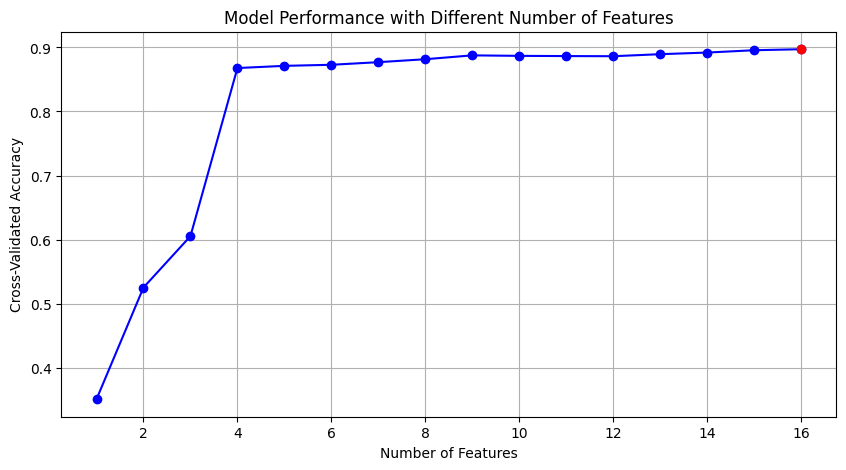

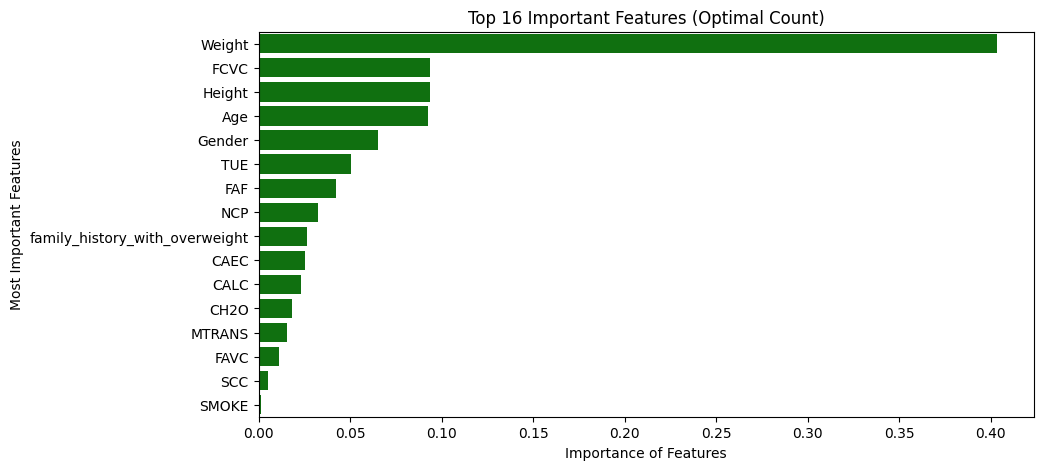

Training Models:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Training Models:  20%|██        | 1/5 [00:02<00:10,  2.51s/it]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Training Models:  40%|████      | 2/5 [21:03<37:09, 743.05s/it]

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Training Models:  60%|██████    | 3/5 [25:10<17:12, 516.13s/it]

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Training Models:  80%|████████  | 4/5 [28:28<06:30, 390.88s/it]

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 20758, number of used features: 16
[LightGBM] [Info] Start training from score -2.107483
[LightGBM] [Info] Start training from score -1.907353
[LightGBM] [Info] Start training from score -2.146276
[LightGBM] [Info] Start training from score -2.107879
[LightGBM] [Info] Start training from score -1.964779
[LightGBM] [Info] Start training from score -1.854892
[LightGBM] [Info] Start training from score -1.635203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 16606, number of u

Training Models: 100%|██████████| 5/5 [33:14<00:00, 398.92s/it]
<ipython-input-26-9e41d209fd0c>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Best Accuracy', data=results_df, palette='viridis')


           Model  Best Accuracy  \
0    Naive Bayes       0.661866   
1            SVM       0.863956   
2  Random Forest       0.897678   
3        XGBoost       0.906350   
4       LightGBM       0.905386   

                                     Best Parameters  
0                                                 {}  
1                        {'C': 10, 'gamma': 'scale'}  
2             {'max_depth': 30, 'n_estimators': 200}  
3  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  
4  {'learning_rate': 0.1, 'n_estimators': 100, 'n...  


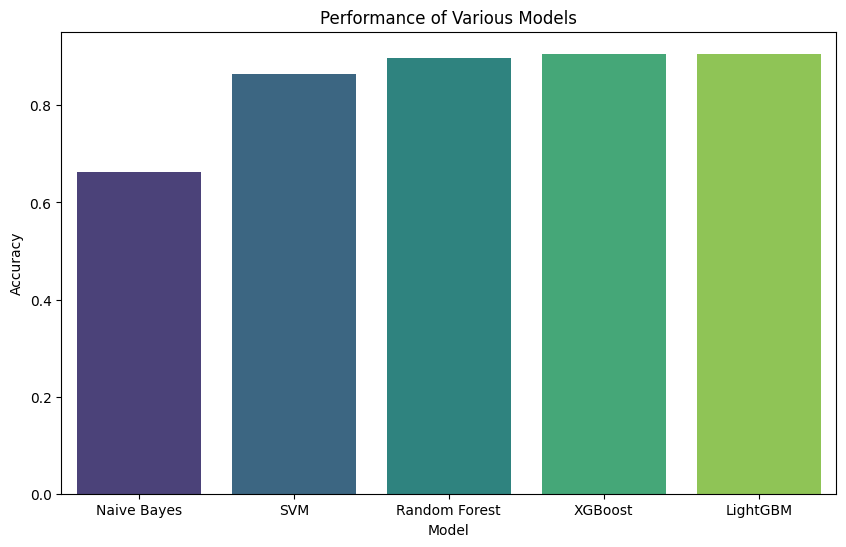

In [26]:
#Avalia inúmeros algoritmos preditivos, testando inúmeros parâmetros com gridsearch
def evaluate_models_with_gridsearch(data, target_col):
    best_features = find_optimal_features(data, target_col)
    X_best = data[best_features]
    y = data[target_col]

    #Normaliza os valores das features.
    scaler = StandardScaler()
    X_best_scaled = scaler.fit_transform(X_best)

    models = {
        'Naive Bayes': (GaussianNB(), {}),
        'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
        'Random Forest': (RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30, None]}),
        'XGBoost': (xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), {'n_estimators': [100, 200], 'max_depth': [5, 10], 'learning_rate': [0.1, 0.01]}),
        'LightGBM': (lgb.LGBMClassifier(), {'n_estimators': [100, 200], 'num_leaves': [31, 64, 128], 'learning_rate': [0.1, 0.01]})
    }

    results = []
    for name, (model, params) in tqdm(models.items(), desc="Training Models"):
        grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
        grid_search.fit(X_best_scaled, y)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        scores = cross_val_score(best_model, X_best_scaled, y, cv=5, scoring='accuracy')
        accuracy = np.mean(scores)
        results.append({'Model': name, 'Best Accuracy': accuracy, 'Best Parameters': best_params})

    results_df = pd.DataFrame(results)
    print(results_df)

    # Plot the model performances for visual comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Best Accuracy', data=results_df, palette='viridis')
    plt.title('Performance of Various Models')
    plt.ylabel('Accuracy')
    plt.show()

    return results_df


results_df = evaluate_models_with_gridsearch(df_transformed, 'NObeyesdad')

# **Treinando o modelo final**

Baseado nos resultados das análises anteriores, da escolha do algoritmo classificador, e dos seus melhores parâmetros, um modelo preditivo de classificação será criado com esses resultados.

In [28]:
#Treina o modelo final usando os melhores parâmetros e o melhor algoritmo descobertos pelo Grid Search e gera relatórios comparativos
def train_final_model(data, target_col, results_df):
    # Mapeamento dos valores categóricos para numéricos e vice-versa
    target_mapping = {
        'Insufficient_Weight': 0,
        'Normal_Weight': 1,
        'Overweight_Level_I': 2,
        'Overweight_Level_II': 3,
        'Obesity_Type_I': 4,
        'Obesity_Type_II': 5,
        'Obesity_Type_III': 6
    }

    reverse_target_mapping = {v: k for k, v in target_mapping.items()}

    if target_col in data.columns:
        # Verificar se a coluna alvo já está mapeada para valores numéricos
        if data[target_col].dtype == object:
            # Verificar se há valores não mapeados na coluna alvo
            unmapped_values = data[~data[target_col].isin(target_mapping.keys())][target_col].unique()
            if len(unmapped_values) > 0:
                print(f"Valores não mapeados encontrados na coluna '{target_col}': {unmapped_values}")
                return None, None

            data[target_col] = data[target_col].map(target_mapping)


    best_model_row = results_df.loc[results_df['Best Accuracy'].idxmax()]
    best_model_name = best_model_row['Model']
    best_params = best_model_row['Best Parameters']

    # Mapeia o nome dos modelos
    model_classes = {
        'Naive Bayes': GaussianNB,
        'SVM': SVC,
        'Random Forest': RandomForestClassifier,
        'XGBoost': xgb.XGBClassifier,
        'LightGBM': lgb.LGBMClassifier
    }

    # Instancia os melhores modelos com as melhores features
    model_class = model_classes[best_model_name]
    model = model_class(**best_params)

    # Prepara e treina o modelo
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    model.fit(X_scaled, y)

    # Realiza a previsão
    y_pred = model.predict(X_scaled)
    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    cr = classification_report(y, y_pred, output_dict=True)

    # Converte os valores de volta para os valores categóricos
    y = y.map(reverse_target_mapping)
    y_pred = pd.Series(y_pred).map(reverse_target_mapping)

    print(f"Final Model: {model_class.__name__}")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y, y_pred))

    plot_confusion_matrix(cm, y)
    plot_classification_report(cr)

    baseline_accuracy = results_df[results_df['Model'] == 'Naive Bayes']['Best Accuracy'].iloc[0]
    compare_model_performance(baseline_accuracy, accuracy, best_model_name)

    return model, scaler

def plot_confusion_matrix(cm, y):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def plot_classification_report(cr):
    report_df = pd.DataFrame(cr).transpose()
    plt.figure(figsize=(12, 8))
    sns.heatmap(report_df.iloc[:-1, :-1].T, annot=True, cmap='Blues', cbar=False)
    plt.title('Classification Report')
    plt.show()

# Compara a performance entre o modelo baseline (Naive Bayes) e o modelo com melhor performance
def compare_model_performance(baseline_accuracy, best_accuracy, best_model_name):
    performances = {'Naive Bayes': baseline_accuracy, best_model_name: best_accuracy}
    plt.figure(figsize=(8, 5))
    bars = plt.bar(performances.keys(), performances.values(), color=['blue', 'green'])
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Model Performance')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    plt.show()


In [29]:
df_transformed.head(2)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,Age_Scale,Weight_Scale,Height_scale,BMI
0,1,24,1.70,81.67,1,1,2.0,2.98,1,0,...,0,0.0,0.98,1,3,3,3,5.0,1.65,28.26
1,0,18,1.56,57.00,1,1,2.0,3.00,2,0,...,0,1.0,1.00,0,0,1,2,3.0,1.55,23.42


In [30]:
#Aplicar a função de feature engineering para o dataset de treino
df_transformed = train.copy()
df_transformed = feature_engineering(df_transformed)
df_transformed = df_transformed.drop(labels=["id"], axis=1)

#Aplicar a função de feature engineering para o dataset de teste
df_test = test.copy()
df_test = feature_engineering(df_test)
df_test = df_test.drop(labels=["id"], axis=1)


Final Model: XGBClassifier
Accuracy: 0.9472974274978322
Confusion Matrix:
 [[2443   75    4    1    0    0    0]
 [  98 2905   63   14    2    0    0]
 [  13  140 2067  181   26    0    0]
 [   0   27  119 2261  108    7    0]
 [   1    2   31   98 2733   40    5]
 [   0    0    0    6   29 3213    0]
 [   1    0    2    0    0    1 4042]]
Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.96      0.97      0.96      2523
      Normal_Weight       0.92      0.94      0.93      3082
     Obesity_Type_I       0.94      0.94      0.94      2910
    Obesity_Type_II       0.99      0.99      0.99      3248
   Obesity_Type_III       1.00      1.00      1.00      4046
 Overweight_Level_I       0.90      0.85      0.88      2427
Overweight_Level_II       0.88      0.90      0.89      2522

           accuracy                           0.95     20758
          macro avg       0.94      0.94      0.94     20758
       weighted avg   

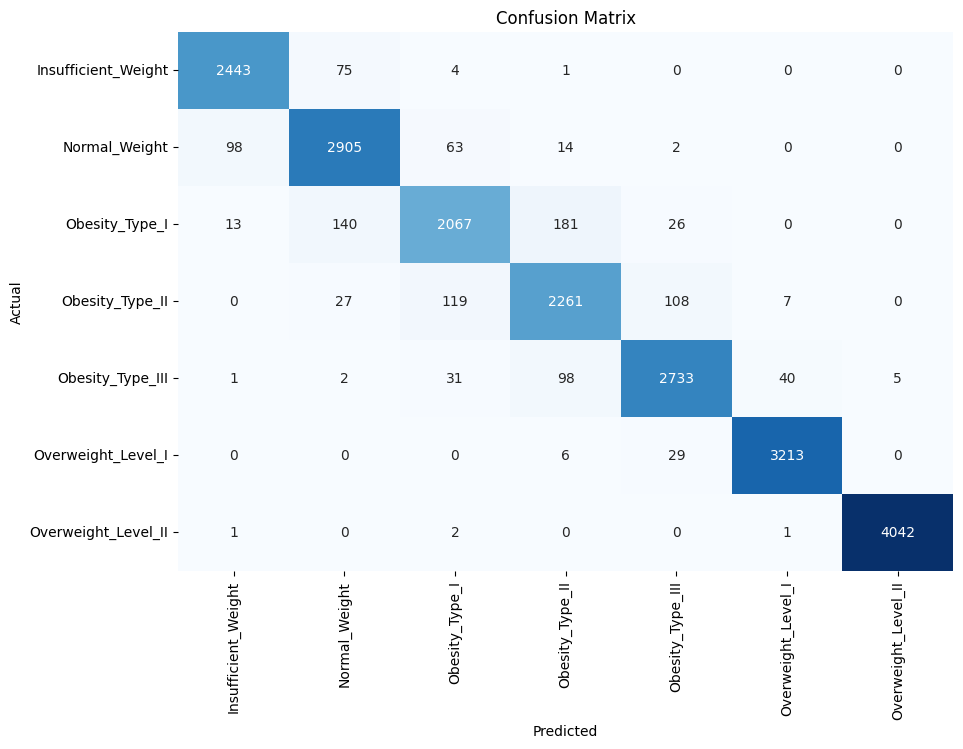

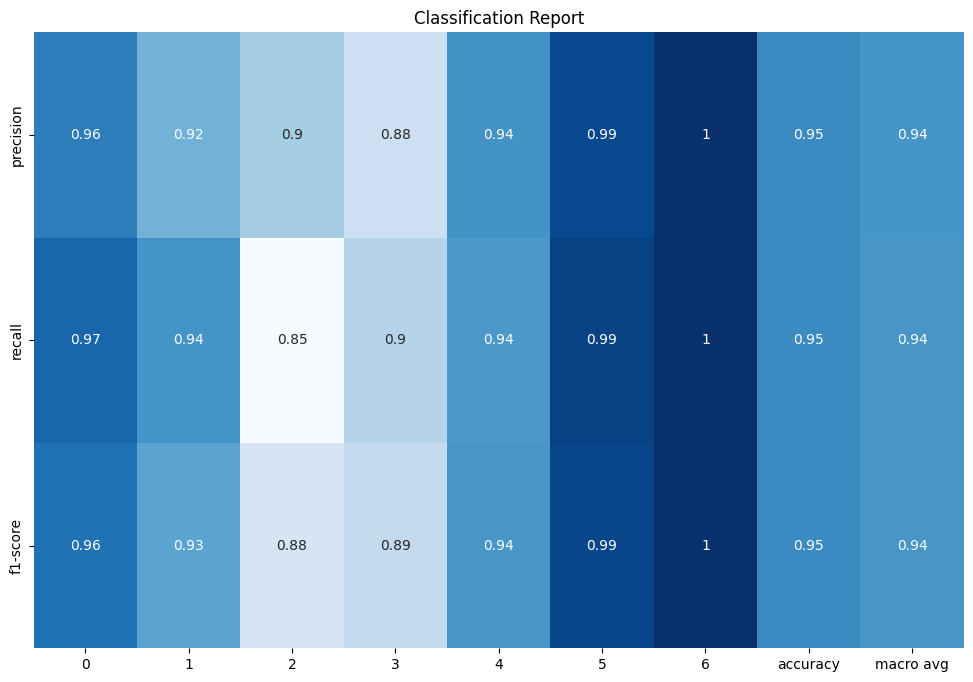

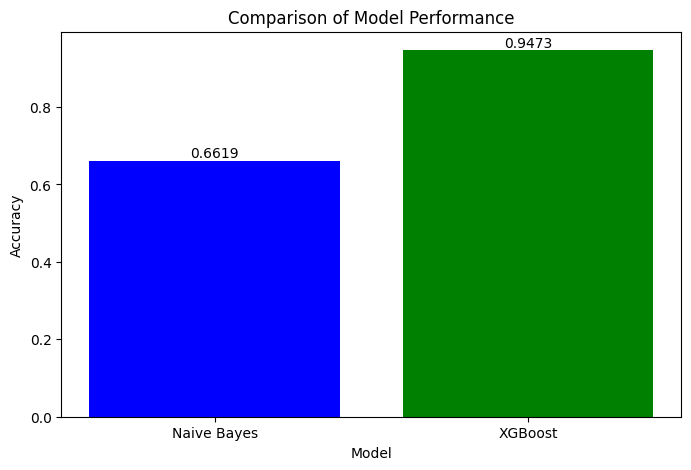

In [31]:
model, scaler = train_final_model(df_transformed, 'NObeyesdad', results_df)

# **Criação do CSV contendo os resultados**

Com o modelo criado no passo anterior e usando o scaler comum. Novos testes precisarão ser feitos com um scaler apropriado.

In [32]:
def prepare_and_submit(model, scaler):

    #Normaliza os dados de teste
    test_scaled = scaler.transform(df_test)

    #Realiza as previsões
    predictions = model.predict(test_scaled)

    #Retorna os valores das variável alvo, para variáveis categóricas
    reverse_mapping = {
        0: 'Insufficient_Weight',
        1: 'Normal_Weight',
        2: 'Overweight_Level_I',
        3: 'Overweight_Level_II',
        4: 'Obesity_Type_I',
        5: 'Obesity_Type_II',
        6: 'Obesity_Type_III'
    }
    predictions = [reverse_mapping[pred] for pred in predictions]

    #Cria e salva o arquivo de submissão
    output_filename = 'submission2.csv'
    #submission = pd.read_csv("/content/sample_submission.csv")
    submission = pd.DataFrame({'id': test['id'], 'NObeyesdad': predictions})
    submission["NObeyesdad"] = predictions
    submission.to_csv(output_filename, index=False)

    print(f"Submission file created: {output_filename}")
    return submission


In [33]:
#Prepara o arquivo de submissão
submission = prepare_and_submit(model,scaler)

Submission file created: submission2.csv


In [34]:
submission.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
